In [14]:
import numpy as np
import numpy.random as random
from scipy import signal
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse #new version: make sure to import scikit-learn (contains new sklearn)
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
def r_2(y, y_hat):

  y_mean = np.mean(y)
  sst = np.sum((y - y_mean) ** 2)
  ssr = np.sum((y - y_hat) ** 2)
  r_squared = 1 - (ssr / sst)

  return r_squared

In [16]:
def dataloader(data, na, nb, d):

    # Initialize empty arrays for lagged features
    y = data['y']
    u = data['u']
    X = pd.DataFrame()


    # Create lagged features for output ('a' parameters)
    for i in range(1,na+1):
        X['y-{}'.format(i)] = y.shift(i)
    # Create lagged features for input ('b' parameters)
    for i in range(0,nb):
        X['u-{}'.format(i + d)] = u.shift(i + d)



    X = X.iloc[max(na,nb+d):]
    # Set the target values
    y = y[max(na,nb+d):]

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    return X, y

## Exercise Session 2: Time Invariant Systems

Text(0.5, 1.0, 'Noisy signal')

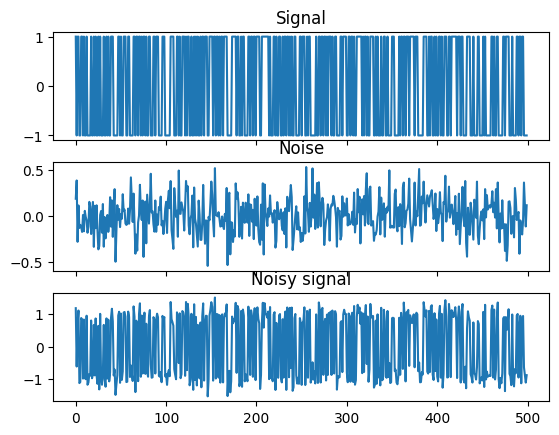

In [17]:
np.random.seed(42)  # You can choose any integer as the seed

# Generate data
n = 500
dt = 1
T = np.linspace(0, (n-1)*dt, n)
s = np.sign(random.randn(n,1))
e = random.randn(n,1) / 5
u = s + e

f, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(s)
ax[0].set_title('Signal')
ax[1].plot(e)
ax[1].set_title('Noise')
ax[2].plot(u)
ax[2].set_title('Noisy signal')


In [18]:
#TEST
a1 = 0.2
b1 = 1.6
b2 = -5.9
d = 4
e = np.random.randn(n, 1) * np.sqrt(0.16)
number_b = 2
number_a = 1

y = np.zeros((n,1))                                     # start with an empty vector for y
for k in range(max(number_b + d, number_a) - 1, n):
    y[k] = -a1 * y[k-1] + b1 * u[k-0-d] + b2 * u[k-1-d] + e[k]

# Plot the input and output signals



In [19]:
print(u[0:5])
print(y[0:5])
print(u.reshape(-1)[0:5])
data = pd.DataFrame([u.reshape(-1), y.reshape(-1)]).T
data.columns = ['u', 'y']
data



[[ 1.18523551]
 [-0.61811667]
 [ 0.72028649]
 [ 1.11259385]
 [-1.13012851]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[ 1.18523551 -0.61811667  0.72028649  1.11259385 -1.13012851]


,u,y
0,1.185236,0.000000
1,-0.618117,0.000000
2,0.720286,0.000000
3,1.112594,0.000000
4,-1.130129,0.000000
...,...,...
495,0.943780,8.569848
496,-0.640463,-2.859218
497,-0.871831,-6.371376
498,-1.114236,9.668123


Check the parameters of the model structure that best fit the data and look up if they match the structure and values we used (remember the sign convention about the a and b parameters, the autoregressive parameters a have flipped sign)

note: to visualize the formula use dark mode in settings

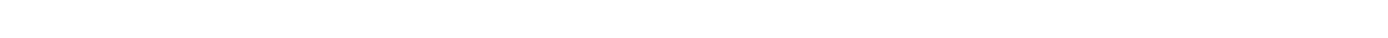

In [20]:
Params=[]
Structure=[]
AIC=[]
RSQ=[]

na_max = nb_max = xdelay_max = 5
model_count=0
for na in range(1,na_max+1):
  for nb in range(1,nb_max+1):
    for d in range(xdelay_max):
      print('\nModel #{} \nwith {} a parameters, {} b parameters and {} time delay'.format(model_count,na,nb,d))
      # Load input data correct format
      X_loader, y_loader = dataloader(data,na,nb,d)
      # Estimate params
      params = np.linalg.inv(X_loader.T @ X_loader) @ X_loader.T @ y_loader
      params = params.values
      parameters_a = params[:na]
      parameters_b = params[na:]

      # 3. Optional: Calculate the predicted values of Y
      Y_pred = X_loader @ params


      # 3.2 Calculate the simulated values of Y
      ysim = np.zeros((len(X_loader)+1,1))  # the plus one is because the first value is initialized and not simulated
      ysim[0] = y_loader.values[0]    # initialize the first value
      max_lag = max(na, nb + d)  # Maximum lag across both endogenous and exogenous variables

      for k in range(max_lag, len(X_loader)):
          # Add the contribution from autoregressive terms (endogenous variables)
          for i_a in range(1, na + 1):
              ysim[k] += parameters_a[i_a-1] * ysim[k - i_a]  # Note: parameters_a starts at index 0

          # Add the contribution from exogenous input terms (with delay d)
          for j_b in range(1, nb + 1):
              ysim[k] += parameters_b[j_b-1] * X_loader['u-{}'.format(d)].iloc[k-j_b]  # Note: parameters_b starts at index 0

      # plt.figure(figsize=(20,6))   # FOR DEBUG
      # plt.plot(y_loader)
      # plt.plot(ysim)
      # plt.show()

      # 4. Calculate R-squared
      y_loader = y_loader.values.reshape(-1,1)
      SS_res = np.sum((y_loader - ysim[1:]) ** 2)  # Residual sum of squares
      SS_tot = np.sum((y_loader - np.mean(y_loader)) ** 2)  # Total sum of squares
      rsq = 1 - (SS_res / SS_tot)

      # 5. Calculate AIC
      n = len(y_loader)  # Number of observations
      k = len(params)  # Number of parameters (including intercept)
      aic = 2 * k + n * np.log(SS_res / n)

      print('RSQ: {}  AIC: {}\n'.format(rsq, aic))

      Params.append(params)
      Structure.append((na,nb,d))
      RSQ.append(rsq)
      AIC.append(aic)
      model_count +=1


Model #0 
with 1 a parameters, 1 b parameters and 0 time delay
RSQ: 0.006316662095936287  AIC: 1869.8857926171488


Model #1 
with 1 a parameters, 1 b parameters and 1 time delay
RSQ: 0.03236489048429758  AIC: 1853.9168031164907


Model #2 
with 1 a parameters, 1 b parameters and 2 time delay
RSQ: 0.01348108096221834  AIC: 1860.8067393023605


Model #3 
with 1 a parameters, 1 b parameters and 3 time delay
RSQ: -0.018781758595522557  AIC: 1874.0310444273955


Model #4 
with 1 a parameters, 1 b parameters and 4 time delay
RSQ: 0.283802790403371  AIC: 1696.8181049859159


Model #5 
with 1 a parameters, 2 b parameters and 0 time delay
RSQ: 0.03182251938921021  AIC: 1856.1958598948158


Model #6 
with 1 a parameters, 2 b parameters and 1 time delay
RSQ: 0.035564296922758865  AIC: 1851.554989026457


Model #7 
with 1 a parameters, 2 b parameters and 2 time delay
RSQ: -0.008418998606914974  AIC: 1870.960038304868


Model #8 
with 1 a parameters, 2 b parameters and 3 time delay
RSQ: 0.2705363

In [21]:
# highest Rsq and lowest AIC (limit complexity)
number_a = 1
number_b = 2
d = 4
parameters = Params[9]

In [35]:
# Simulate model
# Attention! make sure the order of the parameters in the formula is correct, to check which parameters correspond to the endogenous and exogenous variables
# print the relative dataframe and check its columns
n = 500
ysim2 = np.ones((n,1))
e = np.random.randn(n, 1) * np.sqrt(0.16)               # Noise vector e-N(0,0.16), 'standard normal distribution'is mean 0, standard deviation 1.
for k in range(max(number_b + d, number_a) - 1,n):
    ysim2[k] =  parameters[0] * ysim2[k-1]  + parameters[1] * u[k-4] + parameters[2] * u[k-5] + e[k]


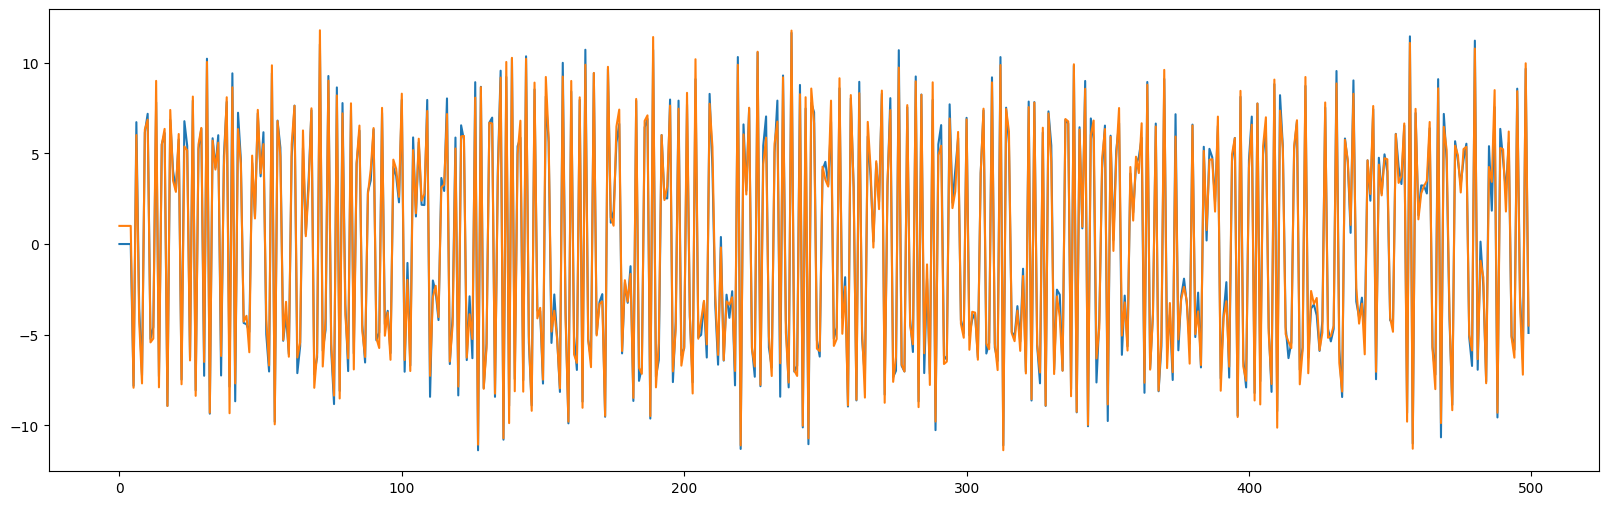

In [36]:
plt.figure(figsize=(20,6))
plt.plot(y)
plt.plot(ysim2)

In [25]:
ysim2.shape

(491, 1)

In [41]:
print(y[0:10])
print(ysim2[0:10])



[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-7.82448203]
 [ 6.72232043]
 [-3.55993547]
 [-7.24070114]
 [ 6.14592425]]
[[ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [-7.92872492]
 [ 6.01076019]
 [-4.26883484]
 [-7.68882198]
 [ 6.31847553]]
